# Orangutan Organoid Scanpy

~15000 Cells from a 10x run. Basic analysis along with trying out my new implementation of RNA velocity analysis. This includes:
Filtering, normalizing, dimension reduction, louvain clustering, DE, gene set scoring, and RNA velocity.

In [1]:
%matplotlib inline

import matplotlib
#matplotlib.use('agg') # plotting backend compatible with screen
import scanpy
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging as logg
import os
import loompy
import scipy
import re
import anndata

results_file = os.path.expanduser('~/Desktop//home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/processedOrangutanOrganoidScanpy.h5ad')

/home/mt/code/utils/miniconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/orangutanorganoid_Pabe3_20180719_S10_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-cellranger-Pabe3_20180719')
#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
sc.tl.addCleanObsNames(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 15312 × 57187 
    obs: 'clean_obs_names'
    var: 'gene_ids'

In [3]:
inputfile = os.path.expanduser('/ye/yelabstore2/mtschmitz/seq/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs')
# Run louvain clustering on true gene expression values
velocityFile = os.path.expanduser('/home/mt/code/data/AlignedOrangutanOrganoid/orangutanorganoid_Pabe3_20180719_S10_Out/velocyto/orangutanorganoid_Pabe3_20180719_S10_Out.loom')
#velocityFile = os.path.expanduser('/ye/yelabstore2/mtschmitz/seq/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/velocyto/orangutanorganoid_Out.loom')

In [4]:
def checkDuplicates(a):
    return(len(a) == len(set(a)))
    
def gsub(regex, sub, l):
    return([re.sub(regex, sub, x) for x in l])

def orderIntersectLists(a,b):
    set(a).intersection(b)

def addCleanObsNames(adata,regex="-[0-9]"):
    try:
        adata.obs.loc[:,"clean_obs_names"]=adata.obs.loc[:,"clean_obs_names"]
    except:
        adata.obs.loc[:,"clean_obs_names"]=adata.obs_names
    adata.obs.loc[:,"clean_obs_names"]=gsub(regex, "",adata.obs.loc[:,"clean_obs_names"])
    return(adata)
    
def removeVelocyto(adata):
    adata.U=None
    adata.S=None
    return(adata)
    
def match(a,b):
    return([ b.index(x) if x in b else None for x in a ])


In [5]:
adata.var_names_make_unique()
adata=addCleanObsNames(adata)

In [6]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=50)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
print(adata.shape)
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
ribo_genes = [name for name in adata.var_names if name.startswith('RPS') or name.startswith('RPL') ]

# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

(6119, 6475)


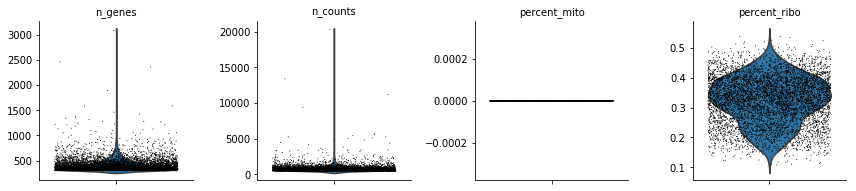

In [8]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','percent_ribo'],
             jitter=0.4, multi_panel=True)

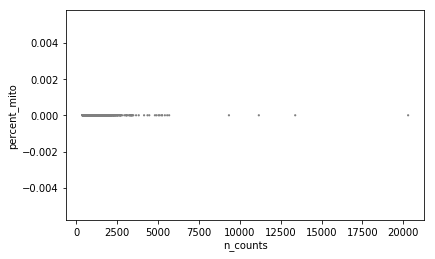

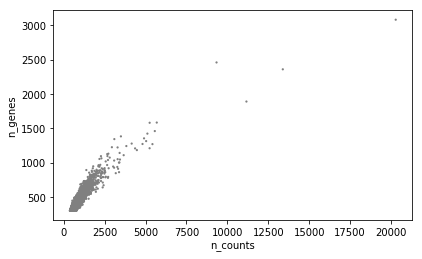

In [9]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [10]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

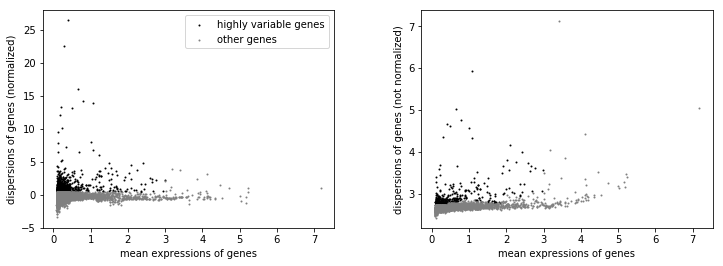

In [12]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [13]:
sc.pp.log1p(adata)

In [14]:
#Are these appropriate???
#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

In [15]:
sc.pp.scale(adata, max_value=10)

In [16]:
import inspect
def funny():
    return(inspect.stack()[0][3])
funny()

'funny'

In [17]:
sc.tl.pca(adata)
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat

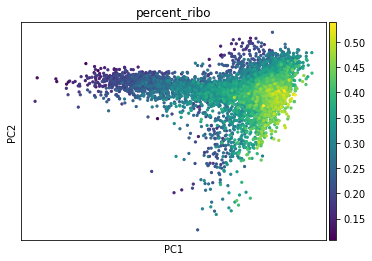

In [18]:
sc.pl.pca_scatter(adata, color='percent_ribo')

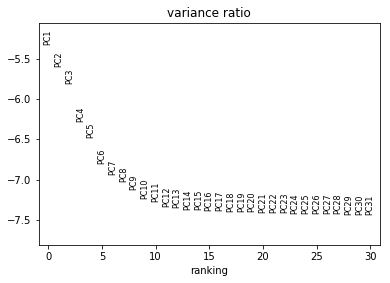

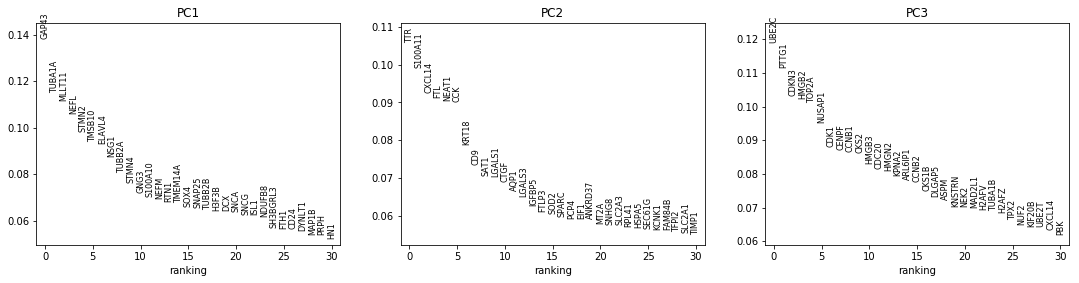

In [19]:
sc.pl.pca_variance_ratio(adata, log=True)
sc.pl.pca_loadings(adata)

In [20]:
sc.tl.tsne(adata, random_state=2, n_pcs=50)

In [21]:
sc.pl.tsne(adata, color=['MKI67','percent_ribo','percent_mito'])

ValueError: Given 'color': MKI67 is not a valid observation or var. Valid observations are: Index(['clean_obs_names', 'n_genes', 'percent_mito', 'percent_ribo',
       'n_counts'],
      dtype='object')

<Figure size 1978.56x288 with 0 Axes>

In [23]:
sc.pp.neighbors(adata, n_neighbors=25)
sc.tl.louvain(adata)

In [24]:
sc.tl.umap(adata)

In [32]:
print(adata.obs)
np.array(adata.obs.groupby(['louvain']).mean().idxmax(axis=1)=='Microglia')

                     clean_obs_names  n_genes  percent_mito  percent_ribo  \
AAACCTGAGCCCTAAT-1  AAACCTGAGCCCTAAT      305           0.0      0.181406   
AAACCTGAGGGTTTCT-1  AAACCTGAGGGTTTCT      356           0.0      0.200382   
AAACCTGCAACGCACC-1  AAACCTGCAACGCACC      304           0.0      0.160173   
AAACCTGCAAGTAATG-1  AAACCTGCAAGTAATG      367           0.0      0.410151   
AAACCTGTCGTATCAG-1  AAACCTGTCGTATCAG      322           0.0      0.415605   
AAACCTGTCTATCCTA-1  AAACCTGTCTATCCTA      367           0.0      0.269481   
AAACCTGTCTGCCAGG-1  AAACCTGTCTGCCAGG      433           0.0      0.353503   
AAACGGGAGAAGGACA-1  AAACGGGAGAAGGACA      557           0.0      0.356744   
AAACGGGAGGAGCGAG-1  AAACGGGAGGAGCGAG      409           0.0      0.200334   
AAACGGGAGTCTCCTC-1  AAACGGGAGTCTCCTC      334           0.0      0.299413   
AAACGGGAGTTCGATC-1  AAACGGGAGTTCGATC      327           0.0      0.224172   
AAACGGGCAAACAACA-1  AAACGGGCAAACAACA      386           0.0      0.322176   

array([ True,  True,  True,  True,  True])

In [22]:
sc.pl.umap(adata, color=['SOX2', 'SATB2', 'MKI67'], use_raw=False)

ValueError: no field of name X_umap

In [ ]:
#Assume 1% doublets per 1,000 cells
print(adata.shape[0]/100000,"doublets")
sc.tl.woublet(adata,expected_doublet_rate=adata.shape[0]/100000)

12163


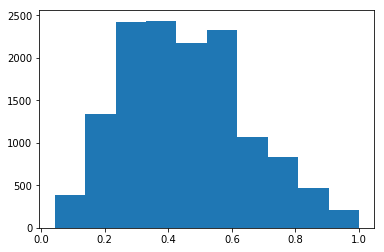

In [32]:
plt. hist(adata.obs['doublet_score'])
print(sum(adata.obs['doublet_score']<.7))


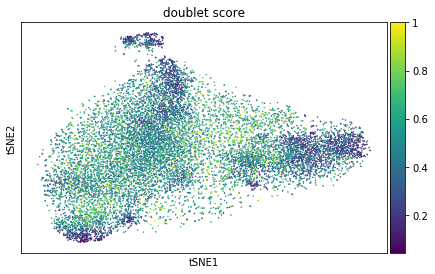

In [33]:
sc.pl.tsne(adata, color='doublet_score')

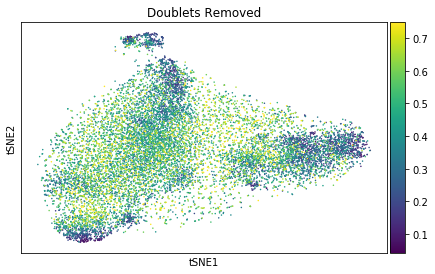

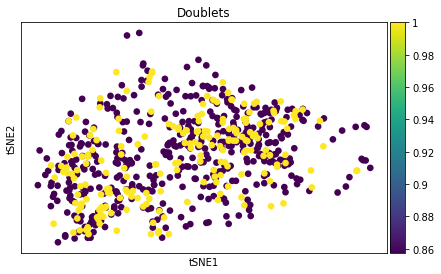

In [34]:
sc.pl.tsne(adata[adata.obs['doublet_score']<.8,:], color='doublet_score',title="Doublets Removed")
sc.pl.tsne(adata[adata.obs['doublet_score']>.8,:], color='doublet_score',title="Doublets")

In [35]:
adata=adata[adata.obs['doublet_score']<.8,:]

In [35]:
sc.tl.louvain(adata)

In [ ]:
sc.pl.umap(adata, color='louvain')


In [48]:
adata.obs['region']=[np.random.choice(['pfc','organoidBS','hypothalamic_cellularz','mge'],p=[.1,.1,.78,.02]) for x in range(adata.obs.shape[0])]

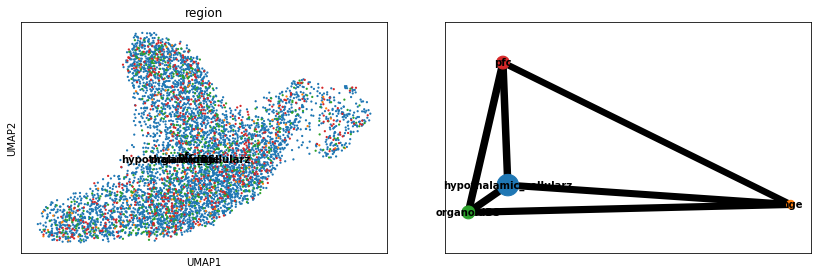

In [60]:
sc.tl.paga(adata,groups='region')
sc.pl.paga_compare(adata)

In [62]:
sc.tl.paga(adata,groups='timepoint')
sc.pl.paga_compare(adata)

AttributeError: Can only use .cat accessor with a 'category' dtype

saving figure to file /home/mt/Desktop/paga_comparePAGA.pdf


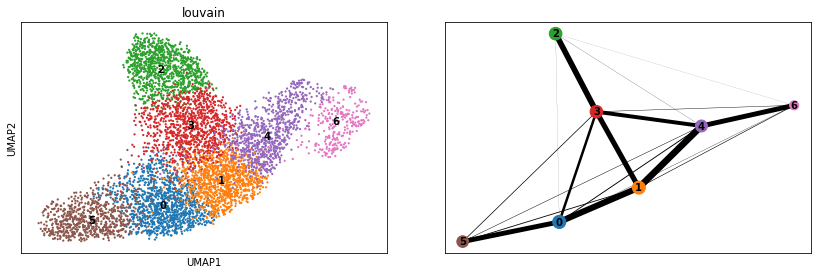

In [65]:
sc.settings.figdir="/home/mt/Desktop/"
sc.tl.paga(adata,groups='louvain')
sc.pl.paga_compare(adata,save="PAGA")

saving figure to file ./figures/rank_genes_groups_louvain.pdf


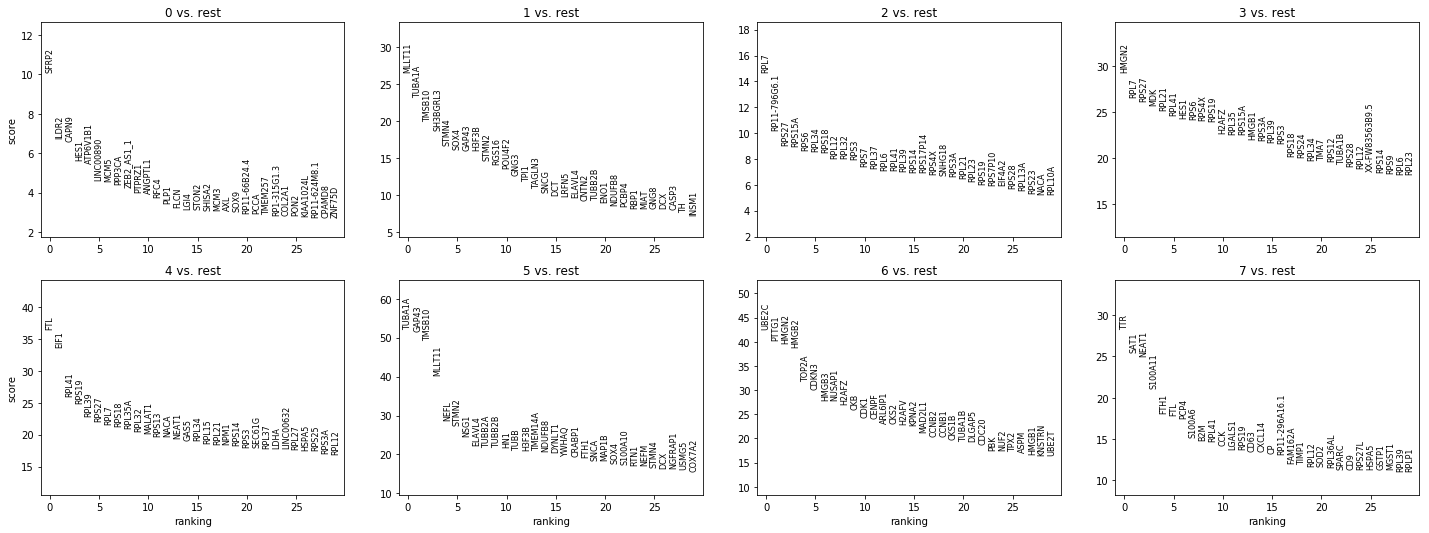

In [38]:
sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=30, save='.pdf')

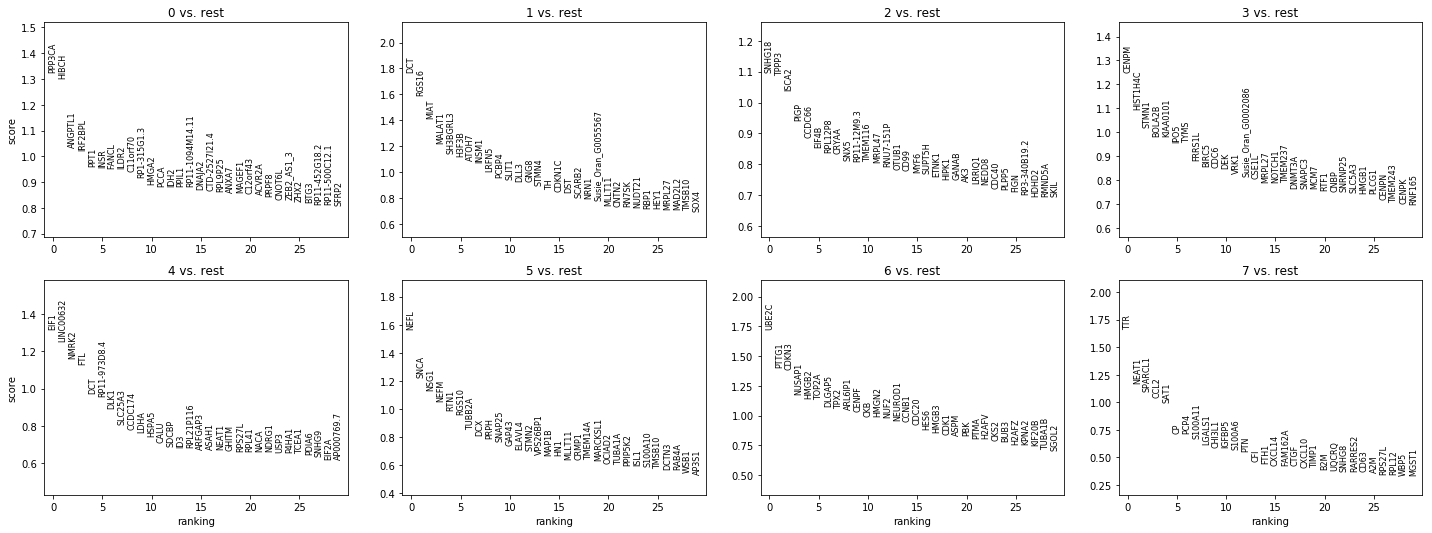

0                    1            2                    3  \
0            PPP3CA                  DCT       SNHG18                CENPM   
1             HIBCH                RGS16        TPPP3             HIST1H4C   
2           ANGPTL1                 MIAT        ISCA2                STMN1   
3           IRF2BPL               MALAT1         PIGP               BOLA2B   
4              PPT1             SH3BGRL3       CCDC66             KIAA0101   
5              INSR                H3F3B        EIF4B                 IPO5   
6             FANCL                ATOH7      RPL12P8                 TYMS   
7             ILDR2                INSM1        CRYAA               FRRS1L   
8          C11orf70                LRFN5         SNX5                BIRC5   
9       RP1-315G1.3                PCBP4  RP11-12M9.3                 CDC6   
10            HMGA2                SLIT1      TMEM116                  DEK   
11             PCCA                 DLL3       MRPL47                 VRK1   
12             IDH2                 GNG8    RNU7-151P  Susie_Oran_G0002086   
13            PPIL1                STMN4        OTUB1                CSE1L   
14  RP11-1094M14.11                   TH         CD99               MRPL27   
15           DNAJA2               CDKN1C         MYF6               NOTCH1   
16    CTD-2527I21.4                  DST       SUPT5H              TMEM237   
17          RPL9P25               SCARB2        ETNK1               DNMT3A   
18            ANXA7                 NRN1        HIPK1               SNAPC3   
19           MAGEF1  Susie_Oran_G0055567        GANAB                 MCM7   

               4         5        6        7  
0           EIF1      NEFL    UBE2C      TTR  
1      LINC00632      SNCA    PTTG1    NEAT1  
2          NMRK2      NSG1    CDKN3  SPARCL1  
3            FTL      NEFM   NUSAP1     CCL2  
4            DCT      RTN1    HMGB2     SAT1  
5   RP11-973D8.4     RGS10    TOP2A       CP  
6           DLK1    TUBB2A   DLGAP5     PCP4  
7        SLC25A3       DCX     TPX2  S100A11  
8        CCDC174      PRPH  ARL6IP1   LGALS1  
9           LDHA    SNAP25    CENPF   CHI3L1  
10         HSPA5     GAP43      CKB   IGFBP5  
11          CALU    ELAVL4    HMGN2   S100A6  
12         SDCBP     STMN2     NUF2      PTN  
13           ID3  VPS26BP1  NEUROD1      CFI  
14     RPL21P116     MAP1B    CCNB1     FTH1  
15       ARFGAP3       HN1    CDC20   CXCL14  
16         ASAH1    MLLT11     HES6  FAM162A  
17         NEAT1     CRMP1    HMGB3     CTGF  
18         GHITM   TMEM14A     CDK1   CXCL10  
19        RPS27L  MARCKSL1     ASPM    TIMP1

In [39]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=30)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)


In [40]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(20)

0_n       0_s                  1_n       1_s          2_n  \
0            PPP3CA  1.327085                  DCT  1.772757       SNHG18   
1             HIBCH  1.304134                RGS16  1.590936        TPPP3   
2           ANGPTL1  1.034947                 MIAT  1.417898        ISCA2   
3           IRF2BPL  1.025430               MALAT1  1.220479         PIGP   
4              PPT1  0.963125             SH3BGRL3  1.147233       CCDC66   
5              INSR  0.956411                H3F3B  1.119783        EIF4B   
6             FANCL  0.953829                ATOH7  1.094990      RPL12P8   
7             ILDR2  0.952676                INSM1  1.077778        CRYAA   
8          C11orf70  0.940843                LRFN5  1.008138         SNX5   
9       RP1-315G1.3  0.919559                PCBP4  0.964308  RP11-12M9.3   
10            HMGA2  0.893594                SLIT1  0.946254      TMEM116   
11             PCCA  0.885461                 DLL3  0.931960       MRPL47   
12             IDH2  0.884790                 GNG8  0.927514    RNU7-151P   
13            PPIL1  0.884450                STMN4  0.898736        OTUB1   
14  RP11-1094M14.11  0.883789                   TH  0.869771         CD99   
15           DNAJA2  0.872953               CDKN1C  0.856816         MYF6   
16    CTD-2527I21.4  0.869362                  DST  0.849478       SUPT5H   
17          RPL9P25  0.866517               SCARB2  0.805615        ETNK1   
18            ANXA7  0.861823                 NRN1  0.799504        HIPK1   
19           MAGEF1  0.859741  Susie_Oran_G0055567  0.782697        GANAB   

         2_s                  3_n       3_s           4_n       4_s       5_n  \
0   1.098918                CENPM  1.251930          EIF1  1.317092      NEFL   
1   1.088907             HIST1H4C  1.098552     LINC00632  1.255343      SNCA   
2   1.038247                STMN1  1.021114         NMRK2  1.165620      NSG1   
3   0.943528               BOLA2B  0.985964           FTL  1.129049      NEFM   
4   0.887291             KIAA0101  0.982382           DCT  0.974527      RTN1   
5   0.854398                 IPO5  0.960983  RP11-973D8.4  0.958133     RGS10   
6   0.840176                 TYMS  0.960115          DLK1  0.891967    TUBB2A   
7   0.836165               FRRS1L  0.884498       SLC25A3  0.806041       DCX   
8   0.811647                BIRC5  0.858482       CCDC174  0.781268      PRPH   
9   0.808893                 CDC6  0.852931          LDHA  0.767837    SNAP25   
10  0.808535                  DEK  0.851975         HSPA5  0.744922     GAP43   
11  0.808198                 VRK1  0.829368          CALU  0.710193    ELAVL4   
12  0.792859  Susie_Oran_G0002086  0.816624         SDCBP  0.689716     STMN2   
13  0.782545                CSE1L  0.806733           ID3  0.686349  VPS26BP1   
14  0.780501               MRPL27  0.794045     RPL21P116  0.682855     MAP1B   
15  0.773118               NOTCH1  0.792391       ARFGAP3  0.676596       HN1   
16  0.771263              TMEM237  0.790737         ASAH1  0.676579    MLLT11   
17  0.761021               DNMT3A  0.766822         NEAT1  0.672498     CRMP1   
18  0.752218               SNAPC3  0.766300         GHITM  0.670941   TMEM14A   
19  0.752026                 MCM7  0.766101        RPS27L  0.666128  MARCKSL1   

         5_s      6_n       6_s      7_n       7_s  
0   1.565541    UBE2C  1.722119      TTR  1.660209  
1   1.226675    PTTG1  1.405075    NEAT1  1.169196  
2   1.135538    CDKN3  1.386359  SPARCL1  1.105088  
3   1.056640   NUSAP1  1.183617     CCL2  1.044830  
4   0.993209    HMGB2  1.145719     SAT1  1.002103  
5   0.961861    TOP2A  1.137358       CP  0.720972  
6   0.856293   DLGAP5  1.076763     PCP4  0.720869  
7   0.811439     TPX2  1.059940  S100A11  0.673376  
8   0.792113  ARL6IP1  1.056525   LGALS1  0.618350  
9   0.769023    CENPF  1.036693   CHI3L1  0.596776  
10  0.744295      CKB  0.994357   IGFBP5  0.589824  
11  0.715976    HMGN2  0.993875   S100A6  0.575310  
12  0.7

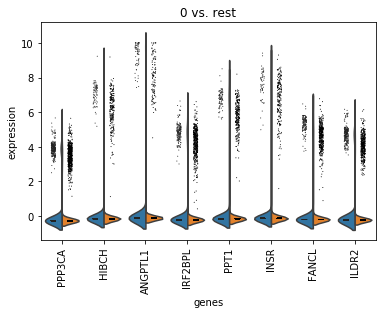

In [41]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8,use_raw=False)

In [ ]:
import os
cell_cycle_genes = [x.strip() for x in open(os.path.expanduser("~/markers/regev_lab_cell_cycle_genes.txt"))]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
print(s_genes)
print(g2m_genes)
print(len(cell_cycle_genes),"cell cycle genes total")
#cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes),"cell cycle genes in this dataset")
#sc.tl.score_genes_cell_cycle(adata,s_genes=s_genes,g2m_genes=g2m_genes)
#adata_cc_genes = adata[:, cell_cycle_genes]
#sc.tl.pca(adata_cc_genes)


... storing 'phase' as categorical


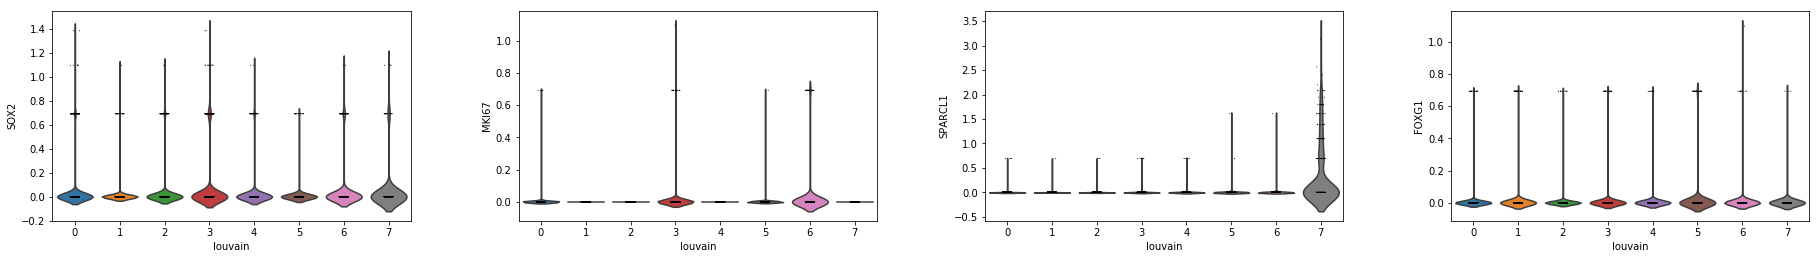

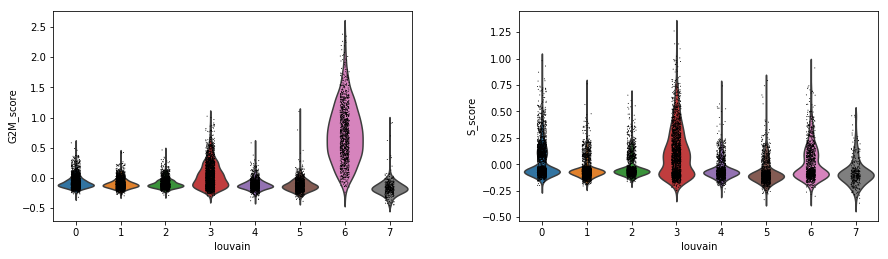

In [43]:
sc.pl.violin(adata, ['SOX2', 'MKI67', 'SPARCL1','FOXG1'], groupby='louvain')
sc.pl.violin(adata, ['G2M_score','S_score'], groupby='louvain')

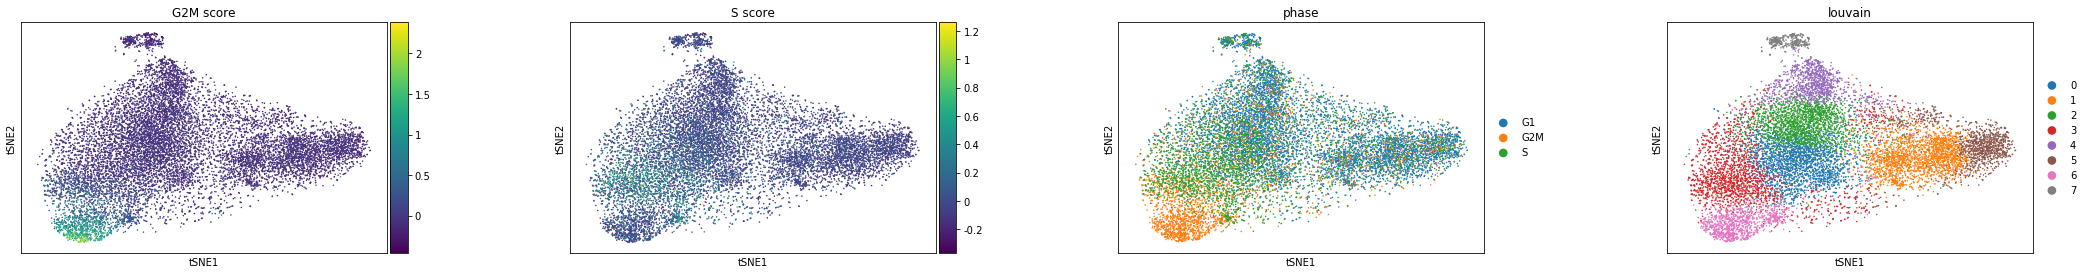

In [44]:
sc.pl.tsne(adata, color=['G2M_score','S_score','phase','louvain'])

In [45]:
#sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

In [46]:
adata.write(results_file)

In [10]:
adata = sc.read(results_file)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [24]:
#markers=pd.read_csv(os.path.expanduser('~/markers/Markers.txt'),sep="\t")
markers=pd.read_csv(os.path.expanduser('https://docs.google.com/spreadsheets/d/e/2PACX-1vTz5a6QncpOOO-f3FHW2Edomn7YM5mOJu4z_y07OE3Q4TzcRr14iZuVyXWHv8rQuejzhhPlEBBH1y0V/pub?gid=1154528422&single=true&output=tsv'),sep="\t")
print(markers)
#Beware of a trailing space on header keys


      hgnc_symbol        alias                            class  \
0             AQP4         NaN                        Astrocyte   
1             CD44         NaN                        Astrocyte   
2              CNP         NaN                        Astrocyte   
3              VIM         NaN                        Astrocyte   
4            S100B       S100β         Astrocyte,Ependymal Cell   
5             RELN      Reelin        Cahal-Retzius Cell,Neuron   
6            CALB2  Calretinin               Cahal-Retzius Cell   
7             TJP1        Zo-1                 Endothelial Cell   
8           SLC2A1      Glut-1                 Endothelial Cell   
9            VCAM1      VCAM-1                 Endothelial Cell   
10            CD24         NaN                   Ependymal Cell   
11            ATF3         NaN                   Ependymal Cell   
12            DLX2         NaN                   Ependymal Cell   
13            TBR2       EOMES     Intermediate Progenitor Cel

In [25]:
markers[markers.keys()[0]]=[str(x) for x in markers[markers.keys()[0]]]
markers[markers.keys()[2]]=[str(x).split(',') for x in markers[markers.keys()[2]]]
markers[markers.keys()[3]]=[str(x).split(';') for x in markers[markers.keys()[3]]]
markers[markers.keys()[3]]=[[str(x).split(',') for x in y] for y in markers[markers.keys()[3]]]
print(markers)

      hgnc_symbol        alias                              class  \
0             AQP4         NaN                        [Astrocyte]   
1             CD44         NaN                        [Astrocyte]   
2              CNP         NaN                        [Astrocyte]   
3              VIM         NaN                        [Astrocyte]   
4            S100B       S100β        [Astrocyte, Ependymal Cell]   
5             RELN      Reelin       [Cahal-Retzius Cell, Neuron]   
6            CALB2  Calretinin               [Cahal-Retzius Cell]   
7             TJP1        Zo-1                 [Endothelial Cell]   
8           SLC2A1      Glut-1                 [Endothelial Cell]   
9            VCAM1      VCAM-1                 [Endothelial Cell]   
10            CD24         NaN                   [Ependymal Cell]   
11            ATF3         NaN                   [Ependymal Cell]   
12            DLX2         NaN                   [Ependymal Cell]   
13            TBR2       EOMES    

In [26]:
uniqueClasses=set([y for x in markers[markers.keys()[2]] for y in x if y!='nan'])
uniqueSubClasses=set([z for x in markers[markers.keys()[3]] for y in x for z in y if z!='nan'])
comboClasses=[]
for i in range(markers.shape[0]):
    rowlist=[]
    for j in range(len(markers[markers.keys()[2]][i])):
        for k in markers[markers.keys()[3]][i][j]:
            rowlist.append(' '.join(filter(lambda x: x != 'nan',[k,markers[markers.keys()[2]][i][j]])))
    comboClasses.append(rowlist)
markers['fullclass']=comboClasses
markers.set_index(markers.keys()[0],inplace=True,drop=False)
markers=markers.loc[ [x for x in markers[markers.keys()[0]] if x in adata.var_names],:]


In [27]:
markers

hgnc_symbol         alias                              class  \
hgnc_symbol                                                                 
CNP                   CNP          NaN                        [Astrocyte]   
CNP                   CNP          NaN                  [Oligodendrocyte]   
VIM                   VIM          NaN                        [Astrocyte]   
RELN                 RELN       Reelin       [Cahal-Retzius Cell, Neuron]   
RELN                 RELN          NaN                           [Neuron]   
SLC2A1             SLC2A1       Glut-1                 [Endothelial Cell]   
CD24                 CD24          NaN                   [Ependymal Cell]   
ATF3                 ATF3          NaN                   [Ependymal Cell]   
LAMP1               LAMP1          NaN                        [Microglia]   
PAX6                 PAX6          NaN                     [Neurectoderm]   
AGTPBP1           AGTPBP1          NaN                           [Neuron]   
MAP2                 MAP2        MAP-2                           [Neuron]   
ENO2                 ENO2          NSE                           [Neuron]   
TH                     TH          NaN                           [Neuron]   
ISL1                 ISL1          NaN                           [Neuron]   
DCX                   DCX          NaN                           [Neuron]   
ASCL1               ASCL1        MASH1                           [Neuron]   
SATB1               SATB1          NaN                           [Neuron]   
FEZF2               FEZF2          NaN                           [Neuron]   
BHLHE22           BHLHE22       BHLHB5                           [Neuron]   
FOXP2               FOXP2          NaN                           [Neuron]   
RORB                 RORB          NaN                           [Neuron]   
CCK                   CCK          NaN                           [Neuron]   
CCDC115           CCDC115          NaN                           [Neuron]   
SPARC               SPARC  Osteonectin                         [Pericyte]   
SOX2                 SOX2          NaN                      [Radial Glia]   
NES                   NES          NaN                      [Radial Glia]   
PROM1               PROM1        CD133                      [Radial Glia]   
FABP7               FABP7         BLBP                      [Radial Glia]   
HES1                 HES1          NaN                      [Radial Glia]   
...                   ...          ...                                ...   
CENPE               CENPE          NaN               [Proliferating Cell]   
CTCF                 CTCF          NaN               [Proliferating Cell]   
NEK2                 NEK2          NaN               [Proliferating Cell]   
G2E3                 G2E3          NaN               [Proliferating Cell]   
GAS2L3             GAS2L3          NaN               [Proliferating Cell]   
CBX5                 CBX5          NaN               [Proliferating Cell]   
MPG                   MPG          NaN                  [Oligodendrocyte]   
CTGF                 CTGF          NaN                           [Neuron]   
PCP4                 PCP4          NaN                           [Neuron]   
NOTCH1             NOTCH1          NaN                     [Neurectoderm]   
NR2E1               NR2E1     Tailless                     [Neurectoderm]   
PAFAH1B1         PAFAH1B1         Lis1                           [Neuron]   
RNF2                 RNF2       Ring1B                      [Radial Glia]   
ID3                   ID3          NaN                        [Astrocyte]   
GJA1                 GJA1          NaN                        [Astrocyte]   
BMPR1B             BMPR1B          NaN                        [Astrocyte]   
CHI3L1             CHI3L1          NaN                        [Astrocyte]   
CLDN10             CLDN10          NaN                        [Astrocyte]   
GPAM                 GPAM          NaN                        [Astrocyte]   
ID4      

In [28]:
uniqueFullClasses=set([y for x in markers['fullclass'] for y in x if y!='nan'])
from collections import defaultdict
markerDict = defaultdict(list)
for x in uniqueFullClasses: 
    for y in markers[markers.keys()[0]]:
        if x in markers.loc[y,'fullclass']:
            markerDict[x].append(y) 
print(markerDict)

markerDictClass = defaultdict(list)
for x in uniqueClasses: 
    for y in markers[markers.keys()[0]]:
        if x in markers.loc[y,'fullclass']:
            markerDictClass[x].append(y) 
print(markerDictClass.keys())


defaultdict(<class 'list'>, {' Ependymal Cell': ['SLC1A3', 'ARL13B'], 'S Phase Proliferating Cell': ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM4', 'RRM1', 'MCM6', 'PRIM1', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'CCNE2', 'UBR7', 'RRM2', 'CDC6', 'DSCC1', 'USP1', 'POLA1'], 'Neuron': ['MAP2', 'ENO2', 'ASCL1', 'FEZF2', 'BHLHE22', 'RORB', 'CCK', 'RAB3C', 'CHGB', 'ARL4C'], 'Dopaminergic Neuron': ['TH'], 'Pericyte': ['SPARC'], 'migrating Neuron': ['CCDC115'], 'Radial Glia': ['SOX2', 'NES', 'PROM1', 'FABP7', 'HES1', 'HES5'], 'Astrocyte': ['VIM', 'BMPR1B', 'CHI3L1', 'CLDN10', 'GPAM', 'ID4'], 'Layer 1 Astrocyte': ['ID3'], 'Migrating Ependymal Cell': ['ATF3'], 'Endothelial Cell': ['SLC2A1', 'APOLD1'], 'Microglia': ['LAMP1'], 'Layer 6 Neuron': ['FOXP2', 'CTGF'], ' Radial Glia': ['SLC1A3', 'ARL13B'], 'Migrating Neuron': ['DCX'], 'Layer 5 Neuron': ['PCP4'], 'Oligodendrocyte Progenitor Cell': ['NFYA'], 'Interneuron Neuron': ['AGTPBP1', 'SATB1', 'CCDC115'], 'Migration pausing Neuron': ['AGTPBP1

200
['SLC1A3', 'ARL13B']
['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM4', 'RRM1', 'MCM6', 'PRIM1', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'CCNE2', 'UBR7', 'RRM2', 'CDC6', 'DSCC1', 'USP1', 'POLA1']
['MAP2', 'ENO2', 'ASCL1', 'FEZF2', 'BHLHE22', 'RORB', 'CCK', 'RAB3C', 'CHGB', 'ARL4C']
['SOX2', 'NES', 'PROM1', 'FABP7', 'HES1', 'HES5']
['VIM', 'BMPR1B', 'CHI3L1', 'CLDN10', 'GPAM', 'ID4']
['SLC2A1', 'APOLD1']
['FOXP2', 'CTGF']
['SLC1A3', 'ARL13B']
['AGTPBP1', 'SATB1', 'CCDC115']
['SATB1', 'CCDC115']
['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5']
['PAX6', 'NOTCH1', 'NR2E1']
['DCX', 'PAFAH1B

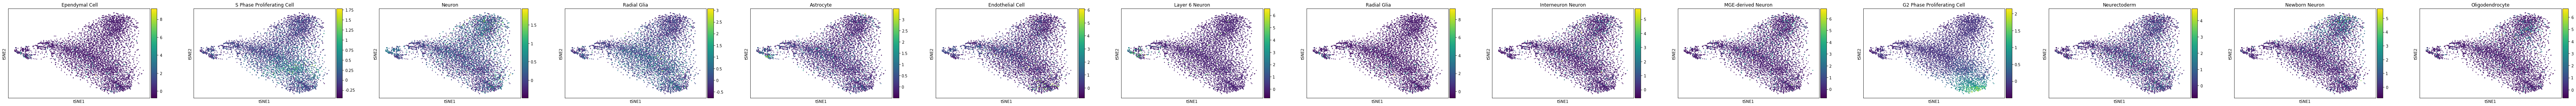

In [29]:
print(min(200,300))
import random
markerPlotGroups=[]
for k in markerDict.keys():
    if len(markerDict[k])>1 and 'G2 Phase' not in markerDict[k] and 'S Phase' not in markerDict[k]:
        print(markerDict[k])
        sc.tl.score_genes(adata,gene_list=markerDict[k],score_name=k,gene_pool= markerDict[k]+random.sample(adata.var.index.tolist(),5000))
        markerPlotGroups.append(k)
sc.pl.tsne(adata,color=markerPlotGroups)




saving figure to file ./figures/tsne_Marker_Group_tsne.pdf


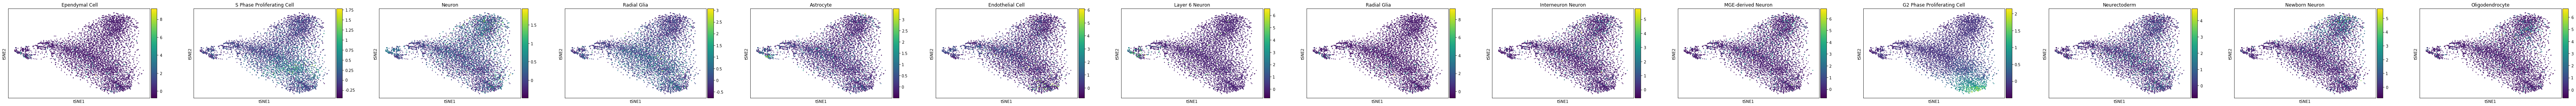

ValueError: Could not interpret input 'louvain'

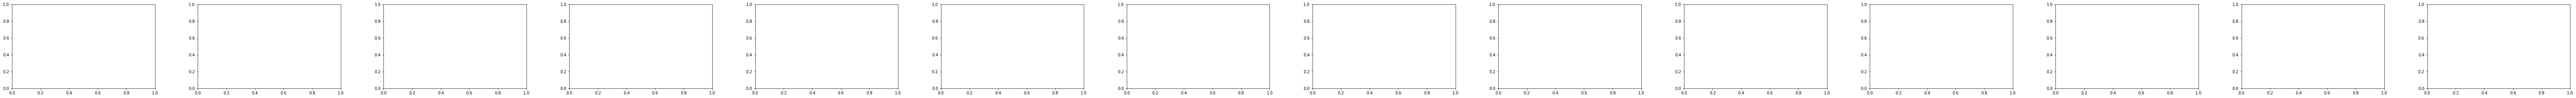

In [30]:
sc.pl.tsne(adata, color=markerPlotGroups,save="_Marker_Group_tsne")
sc.pl.violin(adata, markerPlotGroups, groupby='louvain',save="_Marker_Group_violins")

In [98]:
sc.set_figure_params(color_map="copper")
for i in markerDictClass:
    print(i)
    sc.pl.tsne(adata, color=np.sort(markerDictClass[i]),save="_"+str(i)+"_Marker_tsne")


Microglia
saving figure to file /home/mt/Desktop/tsne_Microglia_Marker_tsne.pdf
Ependymal Cell
saving figure to file /home/mt/Desktop/tsne_Ependymal Cell_Marker_tsne.pdf
Radial Glia
saving figure to file /home/mt/Desktop/tsne_Radial Glia_Marker_tsne.pdf
Astrocyte
saving figure to file /home/mt/Desktop/tsne_Astrocyte_Marker_tsne.pdf
Neurectoderm
saving figure to file /home/mt/Desktop/tsne_Neurectoderm_Marker_tsne.pdf
Oligodendrocyte
saving figure to file /home/mt/Desktop/tsne_Oligodendrocyte_Marker_tsne.pdf
Pluripotent Stem Cell
saving figure to file /home/mt/Desktop/tsne_Pluripotent Stem Cell_Marker_tsne.pdf
Cahal-Retzius Cell
saving figure to file /home/mt/Desktop/tsne_Cahal-Retzius Cell_Marker_tsne.pdf
Intermediate Progenitor Cell
saving figure to file /home/mt/Desktop/tsne_Intermediate Progenitor Cell_Marker_tsne.pdf
Pericyte
saving figure to file /home/mt/Desktop/tsne_Pericyte_Marker_tsne.pdf
Neuron
saving figure to file /home/mt/Desktop/tsne_Neuron_Marker_tsne.pdf
Endothelial Cell

louvain2    0    1    2    3    4
louvain                          
0         517  474  390  241  196
1         474  382  325  192  159
2         390  325  320  169  147
3         241  192  169   90   77
4         196  159  147   77   70


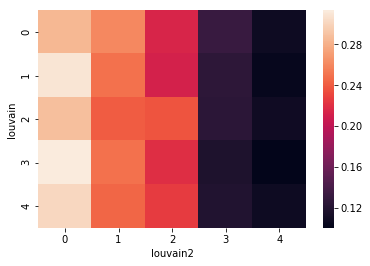

In [103]:
adata.obs['louvain2']=[str(x) for x in reversed(adata.obs['louvain'])]
#print(adata.obs.groupby(['louvain','louvain2'],as_index=False).count())
#print(adata.obs.groupby(['louvain'],as_index=False)['louvain2'])
a=adata.obs.groupby(['louvain','louvain2']).size().unstack(fill_value=0)
print(a)
import seaborn
seaborn.heatmap((a.T/a.sum(axis=1)).T)

In [54]:
def runVelocity(adata,ad_s,ad_u,prefiltered=True):
    if prefiltered:
        subset = list(range(adata.shape[1]))#pd.RangeIndex(len(adata.var_names))
    else:
        subset, _ = sc.pp.filter_genes(ad_u.X, min_cells=10)
        ad_s = ad_s[:, subset]
        ad_u = ad_u[:, subset]

    #ad_s.var_names = np.array(ad_u.var.loc[:,"Gene"])[subset]

    # loop over genes
    from scipy.sparse import dok_matrix
    offset = np.zeros(ad_s.shape[1], dtype='float32')
    gamma = np.zeros(ad_s.shape[1], dtype='float32')
    X_du = dok_matrix(ad_s.shape, dtype='float32')
    for i in range(ad_s.shape[1]):
        x = ad_s.X[:, i].toarray()
        y = ad_u.X[:, i].toarray()
        subset = np.logical_and(x > 0, y > 0)
        x = x[subset]
        y = y[subset]
        X = np.c_[np.ones(len(x)), x]
        offset[i], gamma[i] = np.linalg.pinv(X).dot(y)
        subset_indices = np.flatnonzero(subset)
        index = subset_indices, np.array([i for dummy in subset_indices])
        X_du[index] = y - gamma[i]*x - offset[i]
        #plt.scatter(x, y)
        #plt.scatter(x, gamma[i]*x + offset[i])
        #plt.scatter(x, X_du[index].toarray()[0])
        #plt.show()
    print(X_du)
    adata.var['gamma']=X_du
    X_du = X_du.tocoo().tocsr()
    #Need to run this outside
    #sc.pp.neighbors(adata[:,subset], n_neighbors=100)
    #Also moved this outside
    #graph = compute_velocity_graph(adata, ad_u, X_du)
    return(adata,ad_u,X_du)


In [99]:
loomfile= os.path.expanduser(velocityFile)
###Makesure the addcleanobsnames has been called on adata first
sc.tl.addCleanObsNames(adata)
adata=sc.tl.rna_velocity(adata,loomfile=loomfile,basis='umap')

adding velocyto
                 gene_ids  n_counts            Accession  \
0     Susie_Oran_G0000007    1986.0  Susie_Oran_G0000007   
1     Susie_Oran_G0000011       1.0  Susie_Oran_G0000011   
2     Susie_Oran_G0000014      38.0  Susie_Oran_G0000014   
3     Susie_Oran_G0000020       5.0  Susie_Oran_G0000020   
4     Susie_Oran_G0000024      23.0  Susie_Oran_G0000024   
5     Susie_Oran_G0000025       4.0  Susie_Oran_G0000025   
6     Susie_Oran_G0000030      98.0  Susie_Oran_G0000030   
7     Susie_Oran_G0000047       2.0  Susie_Oran_G0000047   
8     Susie_Oran_G0000052      96.0  Susie_Oran_G0000052   
9     Susie_Oran_G0000056       7.0  Susie_Oran_G0000056   
10    Susie_Oran_G0000067   54232.0  Susie_Oran_G0000067   
11    Susie_Oran_G0000068       2.0  Susie_Oran_G0000068   
12    Susie_Oran_G0000073     685.0  Susie_Oran_G0000073   
13    Susie_Oran_G0000107       1.0  Susie_Oran_G0000107   
14    Susie_Oran_G0000115      80.0  Susie_Oran_G0000115   
15    Susie_Oran_G000011

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
0/7399,


/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/scanpy/tools/rna_velocity.py:174: RuntimeWarning: invalid value encountered in float_scalars
  val = np.dot(du_ji, du_i) / norm(du_ji) / norm(du_i)


1000/7399,
2000/7399,
3000/7399,
4000/7399,
5000/7399,
6000/7399,
7000/7399,


In [56]:
adata.obsm.keys()


('X_pca', 'X_tsne', 'X_umap')

In [100]:
adata=sc.tl.compute_arrows_embedding(adata,basis='umap')

added 'V_umap' to `.obsm`


In [58]:
adata.write(results_file)


In [59]:
adata = sc.read(results_file)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [108]:
sc.tl.plot_velocity_arrows(adata,'umap',cluster='louvain',cluster_colors='louvain_colors')
plt.savefig(os.path.expanduser(sc.settings.figdir +"arrows.pdf"))
plt.c
sc.pl.umap(adata,color='louvain')

'''
#From Velocyto package
ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)

plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
           vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],
           scale=quiver_scale, **quiver_kwargs)
'''

SyntaxError: invalid syntax (<ipython-input-108-05d422722127>, line 5)

In [61]:
sc.tl.paga(adata)
sc.tl.paga_expression_entropies(adata)

[9.5314598,
 9.5304756,
 9.5306025,
 9.5250578,
 9.5302486,
 9.5285559,
 9.5283947,
 9.5295353]

In [ ]:
#sc.pl.paga(adata)
#adata.obs['gamma']=np.ones(shape=adata.obs.shape[0])
adata.obs

In [ ]:
sc.pl.paga_path(adata,[1,4,2,5],keys=['progenitors'])

In [ ]:
sc.tl.score_genes(adata,gene_list=markerDict['Radial Glia'],score_name='Radial Glia')

In [ ]:
plt.hist(adata.obs['Radial Glia'])

In [ ]:
#sc.pl.tsne(adata, color=markerPlotGroups)
sc.pl.violin(adata, markerPlotGroups, groupby='louvain')

In [ ]:
sc.pl.tsne(adata, color='Radial Glia')

In [67]:
sc.settings.figdir=os.path.expanduser("~/Desktop/")
import ScanpyUtilsMT
import importlib.util
import os
spec = importlib.util.spec_from_file_location("ScanpyUtilsMT", os.path.expanduser("~/code/pollye/ScanpyUtilsMT.py"))
sc_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sc_utils)
loomfile="/home/mt/code/data/AlignedOrangutanOrganoid/orangutanorganoid_Pabe3_20180719_S10_Out/velocyto/orangutanorganoid_Pabe3_20180719_S10_Out.loom"

/home/mt/code/pollye/ScanpyUtilsMT.py:11: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/mt/code/utils/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mt/code/utils/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in s

In [69]:
adata=sc_utils.import_file(filename='/home/mt/code/data/AlignedOrangutanOrganoid/orangutanorganoid_Pabe3_20180719_S10_Out/outs/raw_gene_bc_matrices_h5.h5',refname='refdata-cellranger-Pabe3_20180719',save=True)
print("1")
adata=sc_utils.quantify_ribo(adata)
print("2")
adata=sc_utils.quantify_mito(adata)
print("3")
#adata=sc_utils.knee_filter_cells(adata)
adata=sc_utils.filter_custom(adata,n_counts=700,percent_mito=.5,percent_ribo=.5)
print(adata)
adata=sc_utils.std_norm_transform(adata,n_top_genes=6000)
print("5")
dsf
adata=sc_utils.cell_cycle_score(adata)
print("6")
adata=sc_utils.log_reg_diff_exp(adata)
print("7")
adata=sc_utils.marker_analysis(adata)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
AnnData object with n_obs × n_vars = 737280 × 57187 
    obs: 'n_counts'
    var: 'gene_ids'
1


/home/mt/code/pollye/ScanpyUtilsMT.py:144: RuntimeWarning: invalid value encountered in true_divide
  adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1


2
3

/home/mt/code/pollye/ScanpyUtilsMT.py:154: RuntimeWarning: invalid value encountered in true_divide
  adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1



Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
AnnData object with n_obs × n_vars = 3380 × 57187 
    obs: 'n_counts', 'percent_ribo', 'percent_mito'
    var: 'gene_ids'
    uns: 'operations'
AnnData object with n_obs × n_vars = 3380 × 57187 
    obs: 'n_counts', 'percent_ribo', 'percent_mito'
    var: 'gene_ids'
    uns: 'operations'
AnnData object with n_obs × n_vars = 3380 × 5999 
    obs: 'n_counts', 'percent_ribo', 'percent_mito', 'n_counts_all'
    var: 'gene_ids', 'n_counts'
    uns: 'operations'
saving figure to file /home/mt/Desktop/

TypeError: 'bool' object is not callable

In [9]:
    def openVelocyto(adata,loomfile):
        print('adding velocyto')
        ds=loompy.connect(loomfile)
        row_attrs = pd.DataFrame.from_dict(dict(ds.row_attrs.items()))
        col_attrs = pd.DataFrame.from_dict(dict(ds.col_attrs.items()))

        col_attrs.loc[:,"clean_obs_names"] = cell_names = gsub("^[a-zA-Z0-9_]+:", "",col_attrs.loc[:,'CellID'])
        col_attrs.loc[:,"clean_obs_names"] = cell_names = gsub("x","",col_attrs.loc[:,'clean_obs_names'])

        cell_names=list(adata.obs.loc[:,'clean_obs_names'])
        cell_names = [cell for cell in list(col_attrs.loc[:,'clean_obs_names']) if cell in cell_names]
        cell_index = match(list(col_attrs.loc[:,'clean_obs_names']),list(adata.obs.loc[:,'clean_obs_names']))

        gene_names = [gene for gene in row_attrs.loc[:,'Accession'] if gene in adata.var.loc[:,'gene_ids']]
        gene_index = match(list(row_attrs.loc[:,'Accession']),list(adata.var.loc[:,'gene_ids']))

        #cols_to_use = col_attrs.columns.difference( adata.obs.columns)
        adata.obs = pd.merge( adata.obs,col_attrs,how='left',on="clean_obs_names")
        adata.obs.set_index('clean_obs_names',drop=False)

        #cols_to_use = row_attrs.columns.difference(adata.vars.columns)
        vardata=pd.merge( adata.var,row_attrs,how='left',right_on="Accession",left_on="gene_ids")
        adata.var=vardata
        print(adata.var)
        adata.var.set_index('Gene',drop=False)

        if len(cell_names) == 0:
            raise ValueError(
                'Cell names in loom file do not match cell names in AnnData.')

        from anndata.base import _normalize_index
        gene_index=[x for x in gene_index if x is not None]
        cell_index=[x for x in cell_index if x is not None]
        norm_gene_index=_normalize_index(gene_index, pd.RangeIndex(len(gene_index)))
        norm_cell_index=_normalize_index(cell_index, pd.RangeIndex(len(cell_index)))

        #adata.S = anndata.AnnData(ds.layer['spliced'].sparse().tocsr().T)
        #adata.U = anndata.AnnData(ds.layer['unspliced'].sparse().tocsr().T)
        # subset to cells and genes present in adata. Do this with lists of integer indices
        adataS = anndata.AnnData(ds.layer['spliced'].sparse(norm_gene_index,norm_cell_index).tocsr().T)
        adataU = anndata.AnnData(ds.layer['unspliced'].sparse(norm_gene_index,norm_cell_index).tocsr().T)
        adataS.obs=pd.merge( adata.obs,col_attrs,how='left',on="clean_obs_names")
        adataU.obs=pd.merge( adata.obs,col_attrs,how='left',on="clean_obs_names")
        adataS.obs.set_index('clean_obs_names', drop=False)
        adataU.obs.set_index('clean_obs_names', drop=False)
        adataS.var=vardata
        adataU.var=vardata
        adataS.var.set_index('Gene', drop=False)
        adataU.var.set_index('Gene', drop=False)
        adataU.var_names=adataU.var.loc[:,"Gene"]
        adataS.var_names=adataS.var.loc[:,"Gene"]

        ds.close()
        return(adata,adataS,adataU)

adata,adataS,adataU=openVelocyto(adata,loomfile)

adding velocyto


OSError: Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [117]:
print(np.sort(np.sum(adata.X,axis=1)))
adata.var.iloc[np.argsort(np.sum(adata.X,axis=1))]
adata.var.n_cells.sort_values()[::-1].head(100).to_csv(os.path.expanduser("~/Desktop/BroadGenesOrangutan.txt"))

[-806.0669  -805.23083 -794.35565 ... 3467.9595  3759.23    4763.3364 ]


In [123]:
def gsub(regex, sub, l):
    return([re.sub(regex, sub, x) for x in l])

def match(a,b):
    return([ b.index(x) if x in b else None for x in a ])

ds=loompy.connect(loomfile)
row_attrs = pd.DataFrame.from_dict(dict(ds.row_attrs.items()))
col_attrs = pd.DataFrame.from_dict(dict(ds.col_attrs.items()))

col_attrs.loc[:,"clean_obs_names"] = cell_names = gsub("^[a-zA-Z0-9_]+:", "",col_attrs.loc[:,'CellID'])
col_attrs.loc[:,"clean_obs_names"] = cell_names = gsub("x","",col_attrs.loc[:,'clean_obs_names'])

cell_names=list(adata.obs.loc[:,'clean_obs_names'])
cell_names = [cell for cell in list(col_attrs.loc[:,'clean_obs_names']) if cell in cell_names]
cell_index = match(list(col_attrs.loc[:,'clean_obs_names']),list(adata.obs.loc[:,'clean_obs_names']))

gene_names = [gene for gene in row_attrs.loc[:,'Accession'] if gene in adata.var.loc[:,'gene_ids']]
gene_index = match(list(row_attrs.loc[:,'Accession']),list(adata.var.loc[:,'gene_ids']))

#cols_to_use = col_attrs.columns.difference( adata.obs.columns)
adata.obs = pd.merge( adata.obs,col_attrs,how='left',on="clean_obs_names")
adata.obs.set_index('clean_obs_names',drop=False)

#cols_to_use = row_attrs.columns.difference(adata.vars.columns)
vardata=pd.merge( adata.var,row_attrs,how='left',right_on="Accession",left_on="gene_ids")
adata.var=vardata
print(adata.var)
adata.var.set_index('Gene',drop=False)

if len(cell_names) == 0:
    raise ValueError(
        'Cell names in loom file do not match cell names in AnnData.')

from anndata.base import _normalize_index
gene_index=[x for x in gene_index if x is not None]
cell_index=[x for x in cell_index if x is not None]
norm_gene_index=_normalize_index(gene_index, pd.RangeIndex(len(gene_index)))
norm_cell_index=_normalize_index(cell_index, pd.RangeIndex(len(cell_index)))

#adata.S = anndata.AnnData(ds.layer['spliced'].sparse().tocsr().T)
#adata.U = anndata.AnnData(ds.layer['unspliced'].sparse().tocsr().T)
# subset to cells and genes present in adata. Do this with lists of integer indices
adataS = anndata.AnnData(ds.layer['spliced'].sparse(norm_gene_index,norm_cell_index).tocsr().T)
adataU = anndata.AnnData(ds.layer['unspliced'].sparse(norm_gene_index,norm_cell_index).tocsr().T)


                 gene_ids  n_counts          Accession_x  \
0     Susie_Oran_G0000007    1986.0  Susie_Oran_G0000007   
1     Susie_Oran_G0000011       1.0  Susie_Oran_G0000011   
2     Susie_Oran_G0000014      38.0  Susie_Oran_G0000014   
3     Susie_Oran_G0000020       5.0  Susie_Oran_G0000020   
4     Susie_Oran_G0000024      23.0  Susie_Oran_G0000024   
5     Susie_Oran_G0000025       4.0  Susie_Oran_G0000025   
6     Susie_Oran_G0000030      98.0  Susie_Oran_G0000030   
7     Susie_Oran_G0000047       2.0  Susie_Oran_G0000047   
8     Susie_Oran_G0000052      96.0  Susie_Oran_G0000052   
9     Susie_Oran_G0000056       7.0  Susie_Oran_G0000056   
10    Susie_Oran_G0000067   54232.0  Susie_Oran_G0000067   
11    Susie_Oran_G0000068       2.0  Susie_Oran_G0000068   
12    Susie_Oran_G0000073     685.0  Susie_Oran_G0000073   
13    Susie_Oran_G0000107       1.0  Susie_Oran_G0000107   
14    Susie_Oran_G0000115      80.0  Susie_Oran_G0000115   
15    Susie_Oran_G0000117     346.0  Sus

KeyError: 'Gene'

[1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [56]:
import re
def gsub(regex, sub, l):
    return([re.sub(regex, sub, x) for x in l])

l=["E100cingulate","E100_pfc","E100_PFC_S1_AdrpL"]
r="E[0-9]+"
print([float(re.sub("^E","",re.search(r,i).group(0))) for i in l])
print(re.search(r,l[0]).group(0))
print(re.search(r,l[1]).group(0))
print(re.search(r,l[2]).group(0))
r='E[0-9]+'
print(l)
l=gsub(r,"",l)
l=gsub("^_","",l)
l=[i.split('_')[0] for i in l]
print(l)

[100.0, 100.0, 100.0]
E100
E100
E100
['E100cingulate', 'E100_pfc', 'E100_PFC_S1_AdrpL']
['cingulate', 'pfc', 'PFC']


In [153]:
np.array(adata.X[1:10,1:10])

array(<9x9 sparse matrix of type '<class 'numpy.float32'>'
	with 1 stored elements in Compressed Sparse Row format>, dtype=object)

In [74]:
var_subset=sc.pp.filter_genes_dispersion(  # select highly-variable genes
    adata.X, flavor='seurat', n_top_genes=2000, log=True)


/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:308: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/scanpy/preprocessing/simple.py:359: RuntimeWarning: invalid value encountered in greater_equal
  gene_subset = df['dispersion_norm'].values >= disp_cut_off


In [76]:
adata.var.index[var_subset]

IndexError: arrays used as indices must be of integer (or boolean) type

Index(['TLR2', 'RP11-164P12.3', 'RP11-425A23.1', 'GTF2F2P1', 'POU4F2', 'NAA15',
       'TERF1P3', 'ABHD18', 'MFSD8', 'PLK4',
       ...
       'Susie_Oran_G0056525', 'Susie_Oran_G0056529', 'Susie_Oran_G0056537',
       'RNF151', 'Susie_Oran_G0056627', 'Susie_Oran_G0056637', 'OR4N1P',
       'Susie_Oran_G0056807', 'Susie_Oran_G0057097', 'AC004980.9'],
      dtype='object', length=2000)